# Chapter 3: Logistic Regression

## Introduction to Classification with Real Estate Data

Logistic regression is a fundamental algorithm for binary and multiclass classification problems. Unlike linear regression, which predicts continuous values, logistic regression predicts the probability that an instance belongs to a particular category.

### Learning Objectives

By the end of this chapter, you will be able to:

1. **Understand the mathematical foundations** of logistic regression and the sigmoid function
2. **Implement logistic regression** from scratch using gradient descent
3. **Apply feature engineering** techniques for classification problems
4. **Evaluate classification models** using appropriate metrics (accuracy, precision, recall, F1-score, ROC-AUC)
5. **Handle class imbalance** and interpret model coefficients
6. **Compare different regularization techniques** (L1/Lasso and L2/Ridge)

### Real-World Application

We'll use our real estate dataset to predict whether a property is "high-value" (above median price) based on its characteristics. This binary classification problem will demonstrate practical applications of logistic regression in property valuation and market analysis.

### Mathematical Foundation

The logistic regression model uses the **sigmoid function** to map any real-valued input to a value between 0 and 1:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

where $z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$

The probability that an instance belongs to the positive class is:

$$P(y = 1|x) = \sigma(\beta^T x) = \frac{1}{1 + e^{-\beta^T x}}$$

We optimize the **log-likelihood function** using gradient descent to find the optimal parameters $\beta$.

---

**Citation**: Logistic regression foundations are covered in Hastie et al. (2009) "The Elements of Statistical Learning" and James et al. (2013) "An Introduction to Statistical Learning".

In [18]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve, confusion_matrix,
                           classification_report)
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
import sys
import os
from typing import List, Tuple, Optional, Dict
import logging

# Configure matplotlib for enhanced plots
import matplotlib
matplotlib.use('inline')
%matplotlib inline

# Add utils to path and configure plotting
sys.path.append('../utils')
import plot_utils
import data_utils
import evaluation_utils

# Configure enhanced plotting
plot_utils.configure_plotting(style='seaborn-v0_8', figsize=(12, 8))

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("Libraries imported and configured successfully")
print(f"Matplotlib backend: {plt.get_backend()}")
print(f"Plot styling: Enhanced with publication-quality fonts")

INFO:plot_utils:Computer Modern fonts configured successfully


Libraries imported and configured successfully
Matplotlib backend: inline
Plot styling: Enhanced with publication-quality fonts


## 3.1 Data Loading and Exploration

We'll use the real estate dataset from Chapter 2, but this time we'll create a **binary classification problem**: predicting whether a property is "high-value" (above median price) or not.

This approach transforms our regression problem into a classification problem, which is common in real-world scenarios where decision boundaries are more important than exact predictions.

In [19]:
# Load the real estate data
data_path = '../data/processed'
train_file = '2025-08-12_real_estate_train.csv'
test_file = '2025-08-12_real_estate_test.csv'
metadata_file = '2025-08-12_real_estate_metadata.json'

# Load training and test data
df_train = pd.read_csv(os.path.join(data_path, train_file))
df_test = pd.read_csv(os.path.join(data_path, test_file))

# Load metadata for context
with open(os.path.join(data_path, metadata_file), 'r') as f:
    metadata = pd.read_json(f, typ='dict')

print("Dataset Overview:")
print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
print(f"\nColumns: {list(df_train.columns)}")
print(f"\nData types:")
print(df_train.dtypes)

# Display first few rows
print(f"\nFirst 5 rows of training data:")
df_train.head()

Dataset Overview:
Training set shape: (800, 9)
Test set shape: (200, 9)

Columns: ['sqft', 'bedrooms', 'bathrooms', 'age', 'location_score', 'distance_to_center', 'garage', 'school_rating', 'price']

Data types:
sqft                  float64
bedrooms              float64
bathrooms             float64
age                   float64
location_score        float64
distance_to_center    float64
garage                float64
school_rating         float64
price                   int64
dtype: object

First 5 rows of training data:


,sqft,bedrooms,bathrooms,age,location_score,distance_to_center,garage,school_rating,price
0,1192.0,1.0,1.0,24.8,6.4,3.1,0.0,8.0,267064
1,1365.0,1.0,1.0,34.9,7.1,1.9,1.0,5.1,351969
2,1183.0,3.0,2.5,2.1,1.5,3.1,1.0,6.8,284590
3,1127.0,1.0,1.0,3.1,8.7,2.3,1.0,3.5,370622
4,2490.0,4.0,3.5,20.9,4.0,9.7,1.0,7.1,443749


Median property price: $326,100.50

Class Distribution:
Low-value properties (0): 400 (50.0%)
High-value properties (1): 400 (50.0%)


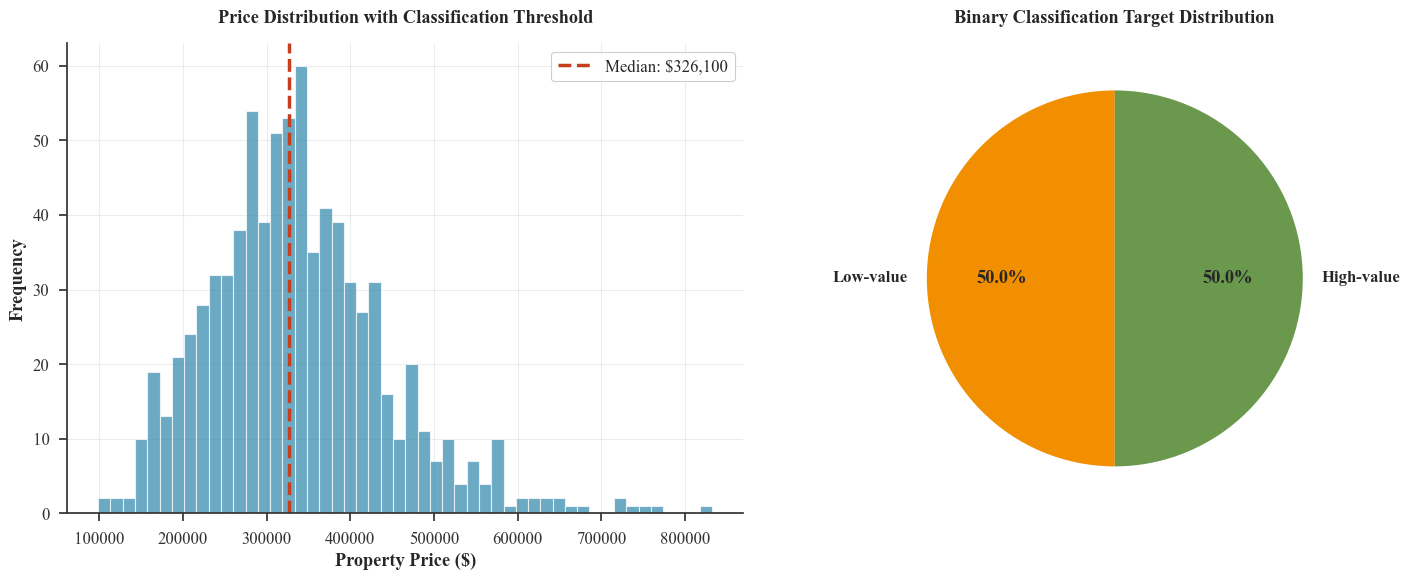


Binary target variable created successfully
Classification threshold: $326,100.50


In [20]:
# Create binary target variable: high-value properties (above median price)
median_price = df_train['price'].median()
print(f"Median property price: ${median_price:,.2f}")

# Create binary target: 1 for high-value (above median), 0 for low-value
df_train['high_value'] = (df_train['price'] > median_price).astype(int)
df_test['high_value'] = (df_test['price'] > median_price).astype(int)

# Analyze class distribution
class_distribution = df_train['high_value'].value_counts()
class_percentages = df_train['high_value'].value_counts(normalize=True) * 100

print(f"\nClass Distribution:")
print(f"Low-value properties (0): {class_distribution[0]} ({class_percentages[0]:.1f}%)")
print(f"High-value properties (1): {class_distribution[1]} ({class_percentages[1]:.1f}%)")

# Visualize price distribution and threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Price distribution with median line
ax1.hist(df_train['price'], bins=50, alpha=0.7, color='#2E86AB', edgecolor='white')
ax1.axvline(median_price, color='#C73E1D', linestyle='--', linewidth=2.5, 
           label=f'Median: ${median_price:,.0f}')
ax1.set_xlabel('Property Price ($)', fontweight='semibold')
ax1.set_ylabel('Frequency', fontweight='semibold')
ax1.set_title('Price Distribution with Classification Threshold', fontweight='bold', pad=15)
ax1.legend()

# Class distribution pie chart
colors = ['#F18F01', '#6A994E']
wedges, texts, autotexts = ax2.pie(class_distribution.values, 
                                  labels=['Low-value', 'High-value'],
                                  colors=colors, autopct='%1.1f%%',
                                  startangle=90, textprops={'fontweight': 'semibold'})
ax2.set_title('Binary Classification Target Distribution', fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print(f"\nBinary target variable created successfully")
print(f"Classification threshold: ${median_price:,.2f}")

## 3.2 Mathematical Foundation: The Sigmoid Function

The core of logistic regression is the **sigmoid function**, which maps any real number to a value between 0 and 1, making it perfect for probability estimation.

### The Sigmoid Function

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

where $z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$

### Key Properties:
- **Range**: $(0, 1)$ - perfect for probabilities
- **S-shaped curve**: smooth transition from 0 to 1
- **Derivative**: $\sigma'(z) = \sigma(z)(1 - \sigma(z))$ - used in gradient descent

Let's visualize the sigmoid function and understand its behavior:

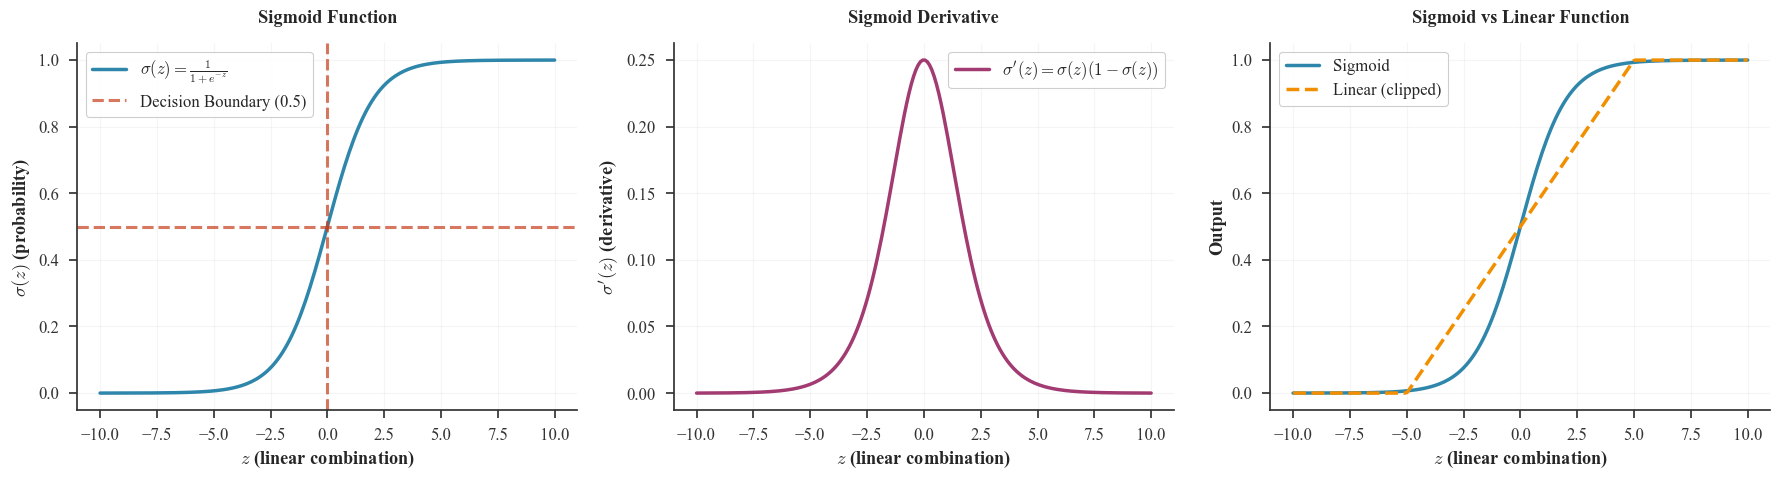

Key Sigmoid Properties:
   • Range: (0, 1) - perfect for probabilities
   • σ(0) = 0.500 - decision boundary
   • σ(-∞) ≈ 0.000045 - approaches 0
   • σ(+∞) ≈ 0.999955 - approaches 1
   • Maximum derivative at z=0: 0.250


In [21]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Compute the sigmoid function.
    
    Parameters
    ----------
    z : np.ndarray
        Input values
        
    Returns
    -------
    np.ndarray
        Sigmoid function output values between 0 and 1
        
    Notes
    -----
    Implements the sigmoid function: σ(z) = 1 / (1 + e^(-z))
    Includes numerical stability for extreme values.
    """
    # Clip z to prevent overflow in exp(-z)
    z_clipped = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z_clipped))

def sigmoid_derivative(z: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of the sigmoid function.
    
    Parameters
    ----------
    z : np.ndarray
        Input values
        
    Returns
    -------
    np.ndarray
        Derivative values
        
    Notes
    -----
    Derivative: σ'(z) = σ(z) * (1 - σ(z))
    """
    s = sigmoid(z)
    return s * (1 - s)

# Visualize sigmoid function and its properties
z_values = np.linspace(-10, 10, 200)
sigmoid_values = sigmoid(z_values)
derivative_values = sigmoid_derivative(z_values)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Sigmoid function
ax1.plot(z_values, sigmoid_values, linewidth=2.5, color='#2E86AB', label=r'$\sigma(z) = \frac{1}{1 + e^{-z}}$')
ax1.axhline(y=0.5, color='#C73E1D', linestyle='--', alpha=0.7, label='Decision Boundary (0.5)')
ax1.axvline(x=0, color='#C73E1D', linestyle='--', alpha=0.7)
ax1.set_xlabel(r'$z$ (linear combination)', fontweight='semibold')
ax1.set_ylabel(r'$\sigma(z)$ (probability)', fontweight='semibold')
ax1.set_title('Sigmoid Function', fontweight='bold', pad=15)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sigmoid derivative
ax2.plot(z_values, derivative_values, linewidth=2.5, color='#A23B72', label=r"$\sigma'(z) = \sigma(z)(1-\sigma(z))$")
ax2.set_xlabel(r'$z$ (linear combination)', fontweight='semibold')
ax2.set_ylabel(r"$\sigma'(z)$ (derivative)", fontweight='semibold')
ax2.set_title('Sigmoid Derivative', fontweight='bold', pad=15)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Comparison with linear function
linear_values = np.clip(0.5 + 0.1 * z_values, 0, 1)  # Linear approximation
ax3.plot(z_values, sigmoid_values, linewidth=2.5, color='#2E86AB', label='Sigmoid')
ax3.plot(z_values, linear_values, linewidth=2.5, color='#F18F01', linestyle='--', label='Linear (clipped)')
ax3.set_xlabel(r'$z$ (linear combination)', fontweight='semibold')
ax3.set_ylabel('Output', fontweight='semibold')
ax3.set_title('Sigmoid vs Linear Function', fontweight='bold', pad=15)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Sigmoid Properties:")
print(f"   • Range: (0, 1) - perfect for probabilities")
print(f"   • σ(0) = {sigmoid(0):.3f} - decision boundary")
print(f"   • σ(-∞) ≈ {sigmoid(-10):.6f} - approaches 0")
print(f"   • σ(+∞) ≈ {sigmoid(10):.6f} - approaches 1")
print(f"   • Maximum derivative at z=0: {sigmoid_derivative(0):.3f}")

## 3.3 Logistic Regression Implementation from Scratch

Now let's implement logistic regression from scratch using gradient descent. This will help us understand the optimization process and cost function.

### Cost Function: Log-Likelihood

The cost function for logistic regression is based on **maximum likelihood estimation**:

$$J(\beta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(h_\beta(x^{(i)})) + (1-y^{(i)}) \log(1-h_\beta(x^{(i)}))]$$

where:
- $h_\beta(x) = \sigma(\beta^T x)$ is the hypothesis function
- $m$ is the number of training examples
- $y^{(i)}$ is the true label (0 or 1)

### Gradient Descent Update

The gradient of the cost function with respect to parameters $\beta$ is:

$$\frac{\partial J}{\partial \beta} = \frac{1}{m} X^T (h_\beta(x) - y)$$

In [22]:
class LogisticRegressionFromScratch:
    """
    Logistic Regression implementation from scratch using gradient descent.
    
    This implementation provides educational insight into the optimization process
    and allows for customization of the learning algorithm.
    
    Parameters
    ----------
    learning_rate : float, default=0.01
        Learning rate for gradient descent
    max_iterations : int, default=1000
        Maximum number of iterations for gradient descent
    tolerance : float, default=1e-6
        Convergence tolerance for early stopping
    regularization : str, default=None
        Regularization type ('l1', 'l2', or None)
    lambda_reg : float, default=0.01
        Regularization strength
        
    Attributes
    ----------
    weights : np.ndarray
        Learned weights (coefficients)
    bias : float
        Learned bias term
    cost_history : list
        History of cost function values during training
    """
    
    def __init__(self, learning_rate: float = 0.01, max_iterations: int = 1000, 
                 tolerance: float = 1e-6, regularization: Optional[str] = None, 
                 lambda_reg: float = 0.01):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.weights = None
        self.bias = None
        self.cost_history = []
        
    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        """Add bias column to feature matrix."""
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def _compute_cost(self, h: np.ndarray, y: np.ndarray) -> float:
        """
        Compute logistic regression cost function with optional regularization.
        
        Parameters
        ----------
        h : np.ndarray
            Predicted probabilities
        y : np.ndarray
            True labels
            
        Returns
        -------
        float
            Cost function value
        """
        # Prevent log(0) by clipping predictions
        h_clipped = np.clip(h, 1e-15, 1 - 1e-15)
        
        # Log-likelihood cost
        cost = (-1/len(y)) * np.sum(y * np.log(h_clipped) + (1 - y) * np.log(1 - h_clipped))
        
        # Add regularization if specified
        if self.regularization == 'l1' and self.weights is not None:
            cost += self.lambda_reg * np.sum(np.abs(self.weights[1:]))  # Exclude bias
        elif self.regularization == 'l2' and self.weights is not None:
            cost += self.lambda_reg * np.sum(self.weights[1:] ** 2)  # Exclude bias
            
        return cost
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LogisticRegressionFromScratch':
        """
        Train the logistic regression model using gradient descent.
        
        Parameters
        ----------
        X : np.ndarray
            Training features
        y : np.ndarray
            Training labels
            
        Returns
        -------
        self : LogisticRegressionFromScratch
            Fitted estimator
        """
        # Add intercept term
        X_with_intercept = self._add_intercept(X)
        
        # Initialize weights
        n_features = X_with_intercept.shape[1]
        self.weights = np.random.normal(0, 0.01, n_features)
        
        # Gradient descent
        prev_cost = float('inf')
        
        for i in range(self.max_iterations):
            # Forward pass
            z = X_with_intercept.dot(self.weights)
            h = sigmoid(z)
            
            # Compute cost
            cost = self._compute_cost(h, y)
            self.cost_history.append(cost)
            
            # Compute gradients
            gradients = (1/len(y)) * X_with_intercept.T.dot(h - y)
            
            # Add regularization to gradients
            if self.regularization == 'l1':
                gradients[1:] += self.lambda_reg * np.sign(self.weights[1:])
            elif self.regularization == 'l2':
                gradients[1:] += 2 * self.lambda_reg * self.weights[1:]
            
            # Update weights
            self.weights -= self.learning_rate * gradients
            
            # Check for convergence
            if abs(prev_cost - cost) < self.tolerance:
                print(f"Converged after {i+1} iterations")
                break
            prev_cost = cost
            
        return self
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict class probabilities.
        
        Parameters
        ----------
        X : np.ndarray
            Input features
            
        Returns
        -------
        np.ndarray
            Predicted probabilities
        """
        X_with_intercept = self._add_intercept(X)
        return sigmoid(X_with_intercept.dot(self.weights))
    
    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """
        Make binary predictions.
        
        Parameters
        ----------
        X : np.ndarray
            Input features
        threshold : float, default=0.5
            Decision threshold
            
        Returns
        -------
        np.ndarray
            Binary predictions
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

print("LogisticRegressionFromScratch class implemented successfully")
print("Features: Gradient descent, regularization, convergence checking")

LogisticRegressionFromScratch class implemented successfully
Features: Gradient descent, regularization, convergence checking


## 3.4 Feature Engineering and Data Preparation

Before training our logistic regression model, we need to prepare our features appropriately. This includes handling categorical variables, scaling numerical features, and selecting relevant features.

Feature Engineering Complete:
   • Training set: (800, 7)
   • Test set: (200, 7)
   • Features: ['sqft', 'bedrooms', 'bathrooms', 'age', 'location_score', 'distance_to_center', 'has_garage']
   • Target distribution (train): [400 400]
Features scaled using StandardScaler
   • Mean: [-0.  0. -0.  0. -0. -0. -0.]
   • Std: [1. 1. 1. 1. 1. 1. 1.]


C:\Users\rabbo\AppData\Local\Temp\ipykernel_73260\1531351263.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(box_data, labels=['Low-value', 'High-value'],
C:\Users\rabbo\AppData\Local\Temp\ipykernel_73260\1531351263.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(box_data, labels=['Low-value', 'High-value'],
C:\Users\rabbo\AppData\Local\Temp\ipykernel_73260\1531351263.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(box_data, labels=['Low-value', 'High-value'],
C:\Users\rabbo\AppData\Local\Temp\ipykernel_73260\1531351263.py:75: MatplotlibDepr

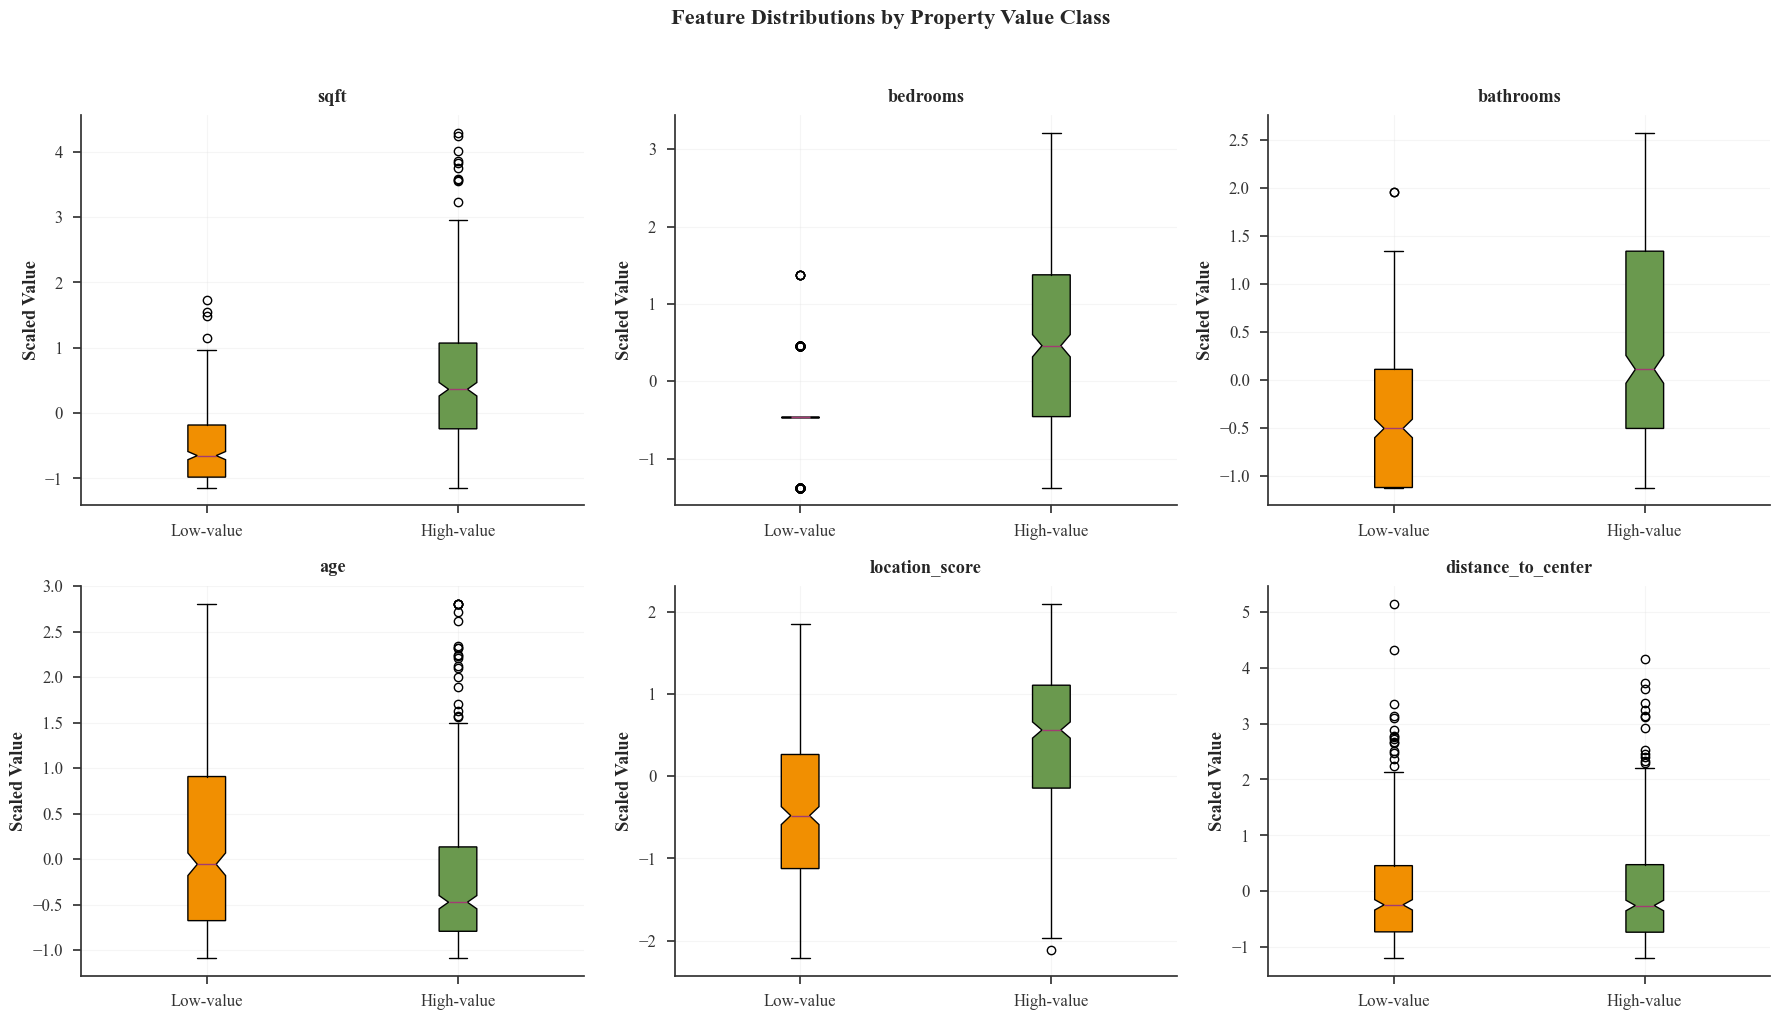


Feature correlations with target:
   • sqft: 0.540
   • bedrooms: 0.498
   • bathrooms: 0.477
   • location_score: 0.443
   • age: -0.213
   • has_garage: 0.191
   • distance_to_center: -0.022


In [23]:
# Prepare features for logistic regression
def prepare_features(df: pd.DataFrame, target_col: str = 'high_value') -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Prepare features for logistic regression modeling.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    target_col : str
        Target column name
        
    Returns
    -------
    Tuple[np.ndarray, np.ndarray, List[str]]
        Features, target, and feature names
    """
    # Select numerical features (exclude price and target)
    numerical_features = ['sqft', 'bedrooms', 'bathrooms', 'age', 'location_score', 'distance_to_center']
    
    # Handle categorical features if they exist
    categorical_features = []
    if 'garage' in df.columns:
        # Convert garage to numerical (0/1)
        df_processed = df.copy()
        df_processed['has_garage'] = df_processed['garage'].astype(int) if df_processed['garage'].dtype == bool else df_processed['garage']
        categorical_features.append('has_garage')
    else:
        df_processed = df.copy()
    
    # Combine all features
    all_features = numerical_features + categorical_features
    feature_names = all_features.copy()
    
    # Extract features and target
    X = df_processed[all_features].values
    y = df_processed[target_col].values
    
    return X, y, feature_names

# Prepare training and test data
X_train, y_train, feature_names = prepare_features(df_train)
X_test, y_test, _ = prepare_features(df_test)

print(f"Feature Engineering Complete:")
print(f"   • Training set: {X_train.shape}")
print(f"   • Test set: {X_test.shape}")
print(f"   • Features: {feature_names}")
print(f"   • Target distribution (train): {np.bincount(y_train)}")

# Scale features for better convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features scaled using StandardScaler")
print(f"   • Mean: {X_train_scaled.mean(axis=0).round(3)}")
print(f"   • Std: {X_train_scaled.std(axis=0).round(3)}")

# Feature correlation analysis
feature_df = pd.DataFrame(X_train_scaled, columns=feature_names)
feature_df['target'] = y_train

# Visualize feature distributions by class
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    if i < len(axes):
        # Box plots for each feature by class
        data_class_0 = feature_df[feature_df['target'] == 0][feature]
        data_class_1 = feature_df[feature_df['target'] == 1][feature]
        
        box_data = [data_class_0, data_class_1]
        bp = axes[i].boxplot(box_data, labels=['Low-value', 'High-value'], 
                            patch_artist=True, notch=True)
        
        # Color the boxes
        bp['boxes'][0].set_facecolor('#F18F01')
        bp['boxes'][1].set_facecolor('#6A994E')
        
        axes[i].set_title(f'{feature}', fontweight='bold', pad=10)
        axes[i].set_ylabel('Scaled Value', fontweight='semibold')
        axes[i].grid(True, alpha=0.3)

plt.suptitle('Feature Distributions by Property Value Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Compute feature correlations with target
correlations = feature_df.corr()['target'].drop('target').sort_values(key=abs, ascending=False)
print(f"\nFeature correlations with target:")
for feature, corr in correlations.items():
    print(f"   • {feature}: {corr:.3f}")

## 3.5 Model Training and Comparison

Now we'll train multiple logistic regression models and compare their performance:

1. **From-scratch implementation** (our custom class)
2. **Scikit-learn implementation** (for comparison)
3. **Regularized versions** (L1 and L2 regularization)

This comparison will help us understand the impact of different implementation approaches and regularization techniques.

Training Logistic Regression Models...

1️Training from-scratch implementation...

2️Training scikit-learn implementation...

3️Training L1 regularized model...

4️Training L2 regularized model...

5️Training from-scratch L2 regularized model...
Converged after 609 iterations

All models trained successfully!


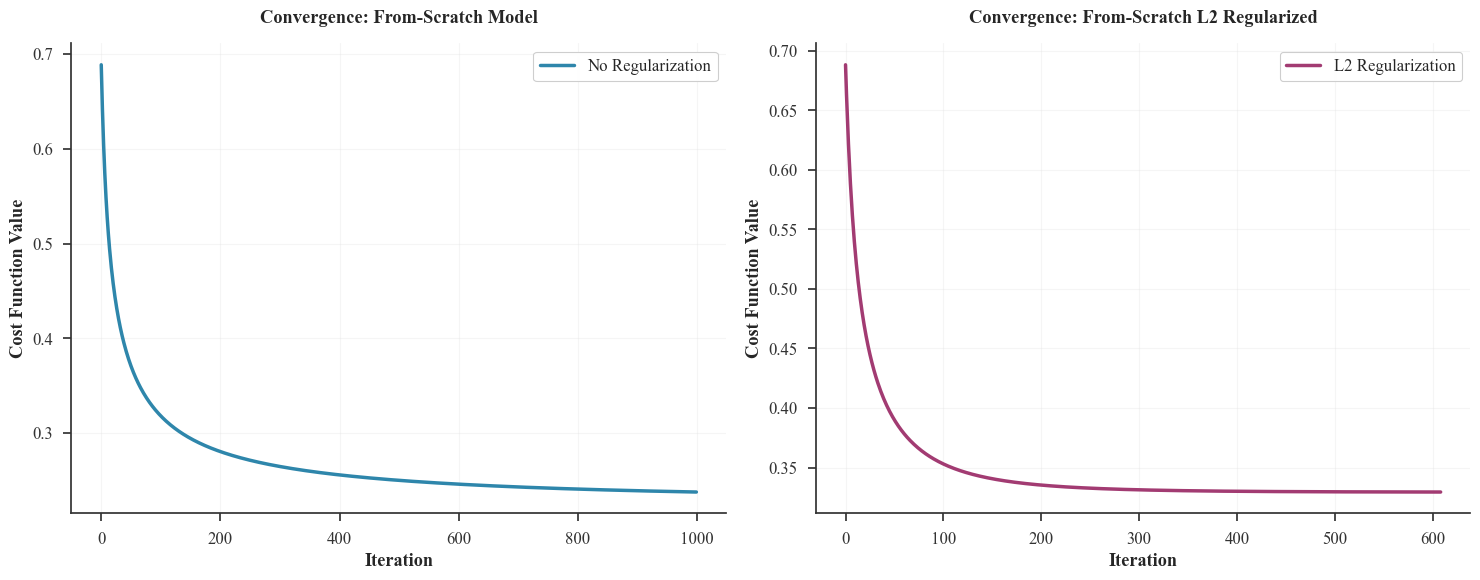

Convergence Analysis:
   • Standard model converged in 1000 iterations
   • L2 regularized model converged in 609 iterations
   • Final cost (standard): 0.2377
   • Final cost (L2): 0.3295


In [24]:
# Train multiple logistic regression models
print("Training Logistic Regression Models...")

# 1. From-scratch implementation
print("\n1️Training from-scratch implementation...")
model_scratch = LogisticRegressionFromScratch(learning_rate=0.1, max_iterations=1000)
model_scratch.fit(X_train_scaled, y_train)

# 2. Scikit-learn standard logistic regression
print("\n2️Training scikit-learn implementation...")
model_sklearn = LogisticRegression(random_state=42, max_iter=1000)
model_sklearn.fit(X_train_scaled, y_train)

# 3. L1 regularized (Lasso)
print("\n3️Training L1 regularized model...")
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
model_l1.fit(X_train_scaled, y_train)

# 4. L2 regularized (Ridge)
print("\n4️Training L2 regularized model...")
model_l2 = LogisticRegression(penalty='l2', random_state=42, max_iter=1000)
model_l2.fit(X_train_scaled, y_train)

# 5. From-scratch with L2 regularization
print("\n5️Training from-scratch L2 regularized model...")
model_scratch_l2 = LogisticRegressionFromScratch(
    learning_rate=0.1, max_iterations=1000, 
    regularization='l2', lambda_reg=0.01
)
model_scratch_l2.fit(X_train_scaled, y_train)

print("\nAll models trained successfully!")

# Visualize convergence for from-scratch models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Regular from-scratch model convergence
ax1.plot(model_scratch.cost_history, linewidth=2.5, color='#2E86AB', label='No Regularization')
ax1.set_xlabel('Iteration', fontweight='semibold')
ax1.set_ylabel('Cost Function Value', fontweight='semibold')
ax1.set_title('Convergence: From-Scratch Model', fontweight='bold', pad=15)
ax1.legend()
ax1.grid(True, alpha=0.3)

# L2 regularized from-scratch model convergence
ax2.plot(model_scratch_l2.cost_history, linewidth=2.5, color='#A23B72', label='L2 Regularization')
ax2.set_xlabel('Iteration', fontweight='semibold')
ax2.set_ylabel('Cost Function Value', fontweight='semibold')
ax2.set_title('Convergence: From-Scratch L2 Regularized', fontweight='bold', pad=15)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Convergence Analysis:")
print(f"   • Standard model converged in {len(model_scratch.cost_history)} iterations")
print(f"   • L2 regularized model converged in {len(model_scratch_l2.cost_history)} iterations")
print(f"   • Final cost (standard): {model_scratch.cost_history[-1]:.4f}")
print(f"   • Final cost (L2): {model_scratch_l2.cost_history[-1]:.4f}")

## 3.6 Model Evaluation and Performance Metrics

For classification problems, we use different metrics than regression. The key metrics for binary classification include:

### Classification Metrics

1. **Accuracy**: Overall correctness $= \frac{TP + TN}{TP + TN + FP + FN}$
2. **Precision**: Positive predictive value $= \frac{TP}{TP + FP}$
3. **Recall** (Sensitivity): True positive rate $= \frac{TP}{TP + FN}$
4. **F1-Score**: Harmonic mean $= 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$
5. **ROC-AUC**: Area under the ROC curve (measures discriminative ability)

Where TP = True Positives, TN = True Negatives, FP = False Positives, FN = False Negatives

Model Evaluation Results:

From-Scratch:
  Train - Acc: 0.899, Prec: 0.906, Rec: 0.890, F1: 0.898, AUC: 0.967
  Test  - Acc: 0.860, Prec: 0.873, Rec: 0.856, F1: 0.864, AUC: 0.953

Scikit-Learn:
  Train - Acc: 0.897, Prec: 0.899, Rec: 0.895, F1: 0.897, AUC: 0.968
  Test  - Acc: 0.860, Prec: 0.873, Rec: 0.856, F1: 0.864, AUC: 0.953

L1 Regularized:
  Train - Acc: 0.894, Prec: 0.901, Rec: 0.885, F1: 0.893, AUC: 0.968
  Test  - Acc: 0.855, Prec: 0.871, Rec: 0.846, F1: 0.859, AUC: 0.952

L2 Regularized:
  Train - Acc: 0.897, Prec: 0.899, Rec: 0.895, F1: 0.897, AUC: 0.968
  Test  - Acc: 0.860, Prec: 0.873, Rec: 0.856, F1: 0.864, AUC: 0.953

From-Scratch L2:
  Train - Acc: 0.895, Prec: 0.903, Rec: 0.885, F1: 0.894, AUC: 0.964
  Test  - Acc: 0.885, Prec: 0.901, Rec: 0.875, F1: 0.888, AUC: 0.951

Evaluation complete - all models assessed on train and test sets


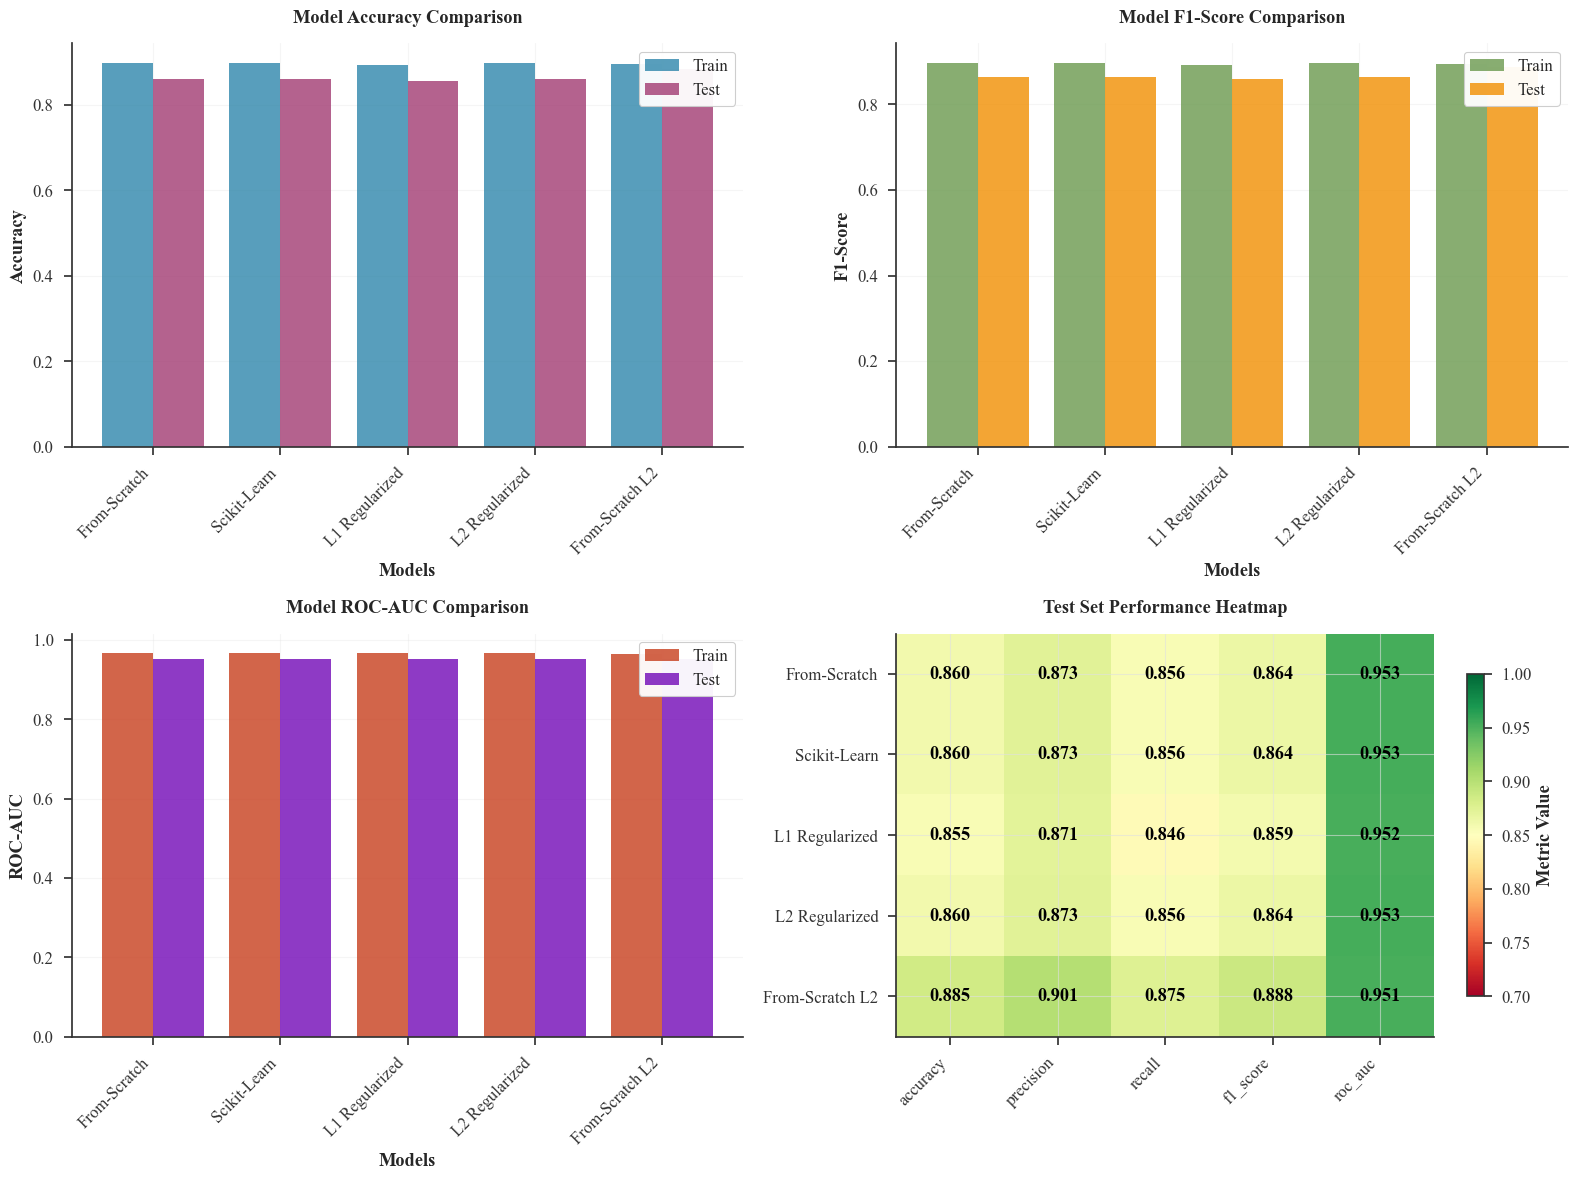


Best performing model (Test F1-Score): From-Scratch L2
Highest test accuracy: 0.885
Highest test ROC-AUC: 0.953


In [25]:
# Comprehensive model evaluation
def evaluate_model(model, X, y, model_name: str, is_scratch: bool = False) -> Dict[str, float]:
    """
    Evaluate a logistic regression model with comprehensive metrics.
    
    Parameters
    ----------
    model : object
        Trained model
    X : np.ndarray
        Features
    y : np.ndarray
        True labels
    model_name : str
        Name of the model for display
    is_scratch : bool
        Whether this is our from-scratch implementation
        
    Returns
    -------
    Dict[str, float]
        Dictionary of evaluation metrics
    """
    # Get predictions
    if is_scratch:
        y_pred_proba = model.predict_proba(X)
        y_pred = model.predict(X)
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]  # Probability of positive class
        y_pred = model.predict(X)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1_score': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_pred_proba)
    }
    
    return metrics, y_pred, y_pred_proba

# Evaluate all models
models = {
    'From-Scratch': (model_scratch, True),
    'Scikit-Learn': (model_sklearn, False),
    'L1 Regularized': (model_l1, False),
    'L2 Regularized': (model_l2, False),
    'From-Scratch L2': (model_scratch_l2, True)
}

train_results = {}
test_results = {}

print("Model Evaluation Results:")
print("=" * 80)

for name, (model, is_scratch) in models.items():
    # Evaluate on training set
    train_metrics, train_pred, train_proba = evaluate_model(
        model, X_train_scaled, y_train, name, is_scratch
    )
    train_results[name] = train_metrics
    
    # Evaluate on test set
    test_metrics, test_pred, test_proba = evaluate_model(
        model, X_test_scaled, y_test, name, is_scratch
    )
    test_results[name] = test_metrics
    
    print(f"\n{name}:")
    print(f"  Train - Acc: {train_metrics['accuracy']:.3f}, Prec: {train_metrics['precision']:.3f}, "
          f"Rec: {train_metrics['recall']:.3f}, F1: {train_metrics['f1_score']:.3f}, AUC: {train_metrics['roc_auc']:.3f}")
    print(f"  Test  - Acc: {test_metrics['accuracy']:.3f}, Prec: {test_metrics['precision']:.3f}, "
          f"Rec: {test_metrics['recall']:.3f}, F1: {test_metrics['f1_score']:.3f}, AUC: {test_metrics['roc_auc']:.3f}")

# Create results DataFrame for better visualization
train_df = pd.DataFrame(train_results).T
test_df = pd.DataFrame(test_results).T

print(f"\nEvaluation complete - all models assessed on train and test sets")

# Visualize model comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
train_acc = train_df['accuracy']
test_acc = test_df['accuracy']
x_pos = np.arange(len(train_acc))

ax1.bar(x_pos - 0.2, train_acc, 0.4, label='Train', color='#2E86AB', alpha=0.8)
ax1.bar(x_pos + 0.2, test_acc, 0.4, label='Test', color='#A23B72', alpha=0.8)
ax1.set_xlabel('Models', fontweight='semibold')
ax1.set_ylabel('Accuracy', fontweight='semibold')
ax1.set_title('Model Accuracy Comparison', fontweight='bold', pad=15)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(train_acc.index, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# F1-Score comparison
train_f1 = train_df['f1_score']
test_f1 = test_df['f1_score']

ax2.bar(x_pos - 0.2, train_f1, 0.4, label='Train', color='#6A994E', alpha=0.8)
ax2.bar(x_pos + 0.2, test_f1, 0.4, label='Test', color='#F18F01', alpha=0.8)
ax2.set_xlabel('Models', fontweight='semibold')
ax2.set_ylabel('F1-Score', fontweight='semibold')
ax2.set_title('Model F1-Score Comparison', fontweight='bold', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(train_f1.index, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# ROC-AUC comparison
train_auc = train_df['roc_auc']
test_auc = test_df['roc_auc']

ax3.bar(x_pos - 0.2, train_auc, 0.4, label='Train', color='#C73E1D', alpha=0.8)
ax3.bar(x_pos + 0.2, test_auc, 0.4, label='Test', color='#7209B7', alpha=0.8)
ax3.set_xlabel('Models', fontweight='semibold')
ax3.set_ylabel('ROC-AUC', fontweight='semibold')
ax3.set_title('Model ROC-AUC Comparison', fontweight='bold', pad=15)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(train_auc.index, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Overall performance heatmap
metrics_for_heatmap = test_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
im = ax4.imshow(metrics_for_heatmap.values, cmap='RdYlGn', aspect='auto', vmin=0.7, vmax=1.0)

# Add text annotations
for i in range(len(metrics_for_heatmap.index)):
    for j in range(len(metrics_for_heatmap.columns)):
        text = ax4.text(j, i, f'{metrics_for_heatmap.iloc[i, j]:.3f}',
                       ha="center", va="center", color="black", fontweight='bold')

ax4.set_xticks(range(len(metrics_for_heatmap.columns)))
ax4.set_yticks(range(len(metrics_for_heatmap.index)))
ax4.set_xticklabels(metrics_for_heatmap.columns, rotation=45, ha='right')
ax4.set_yticklabels(metrics_for_heatmap.index)
ax4.set_title('Test Set Performance Heatmap', fontweight='bold', pad=15)

# Add colorbar
cbar = plt.colorbar(im, ax=ax4, shrink=0.8)
cbar.set_label('Metric Value', fontweight='semibold')

plt.tight_layout()
plt.show()

print(f"\nBest performing model (Test F1-Score): {test_df['f1_score'].idxmax()}")
print(f"Highest test accuracy: {test_df['accuracy'].max():.3f}")
print(f"Highest test ROC-AUC: {test_df['roc_auc'].max():.3f}")

## 3.7 ROC Curve Analysis and Threshold Optimization

The **Receiver Operating Characteristic (ROC)** curve is a powerful tool for evaluating binary classifiers. It plots the **True Positive Rate** (sensitivity) against the **False Positive Rate** (1 - specificity) at various threshold settings.

### Key Concepts:
- **Perfect classifier**: ROC curve passes through (0,1) with AUC = 1.0
- **Random classifier**: Diagonal line with AUC = 0.5
- **AUC interpretation**: Probability that the model ranks a random positive instance higher than a random negative instance

Let's analyze the ROC curves for our models and find optimal decision thresholds:

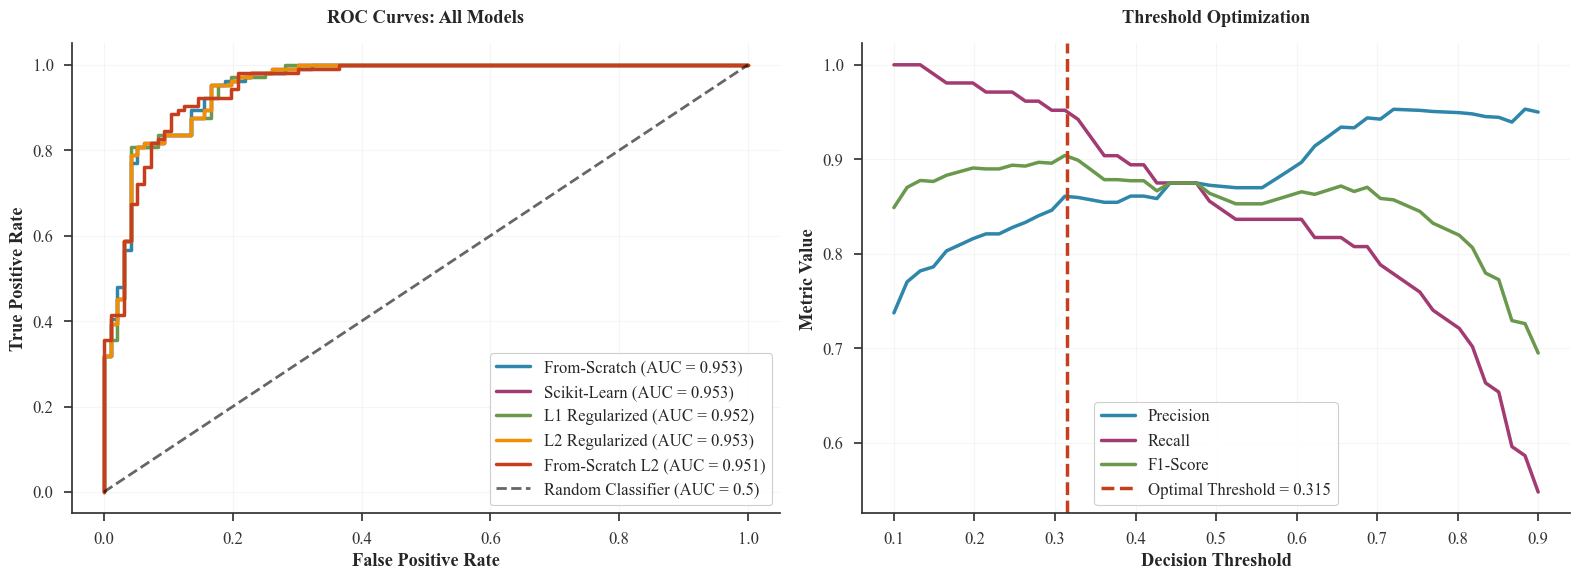

Optimal Threshold Analysis:
   • Optimal threshold: 0.315
   • Youden's J statistic: 0.785

Performance with optimal threshold:
   • Accuracy: 0.895
   • Precision: 0.861
   • Recall: 0.952
   • F1_score: 0.904

Comparison:
   • F1-Score (default 0.5): 0.864
   • F1-Score (optimal 0.315): 0.904
   • Improvement: 4.6%


In [26]:
# ROC Curve Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#2E86AB', '#A23B72', '#6A994E', '#F18F01', '#C73E1D']

# Plot ROC curves for all models
for i, (name, (model, is_scratch)) in enumerate(models.items()):
    # Get predictions
    if is_scratch:
        y_pred_proba = model.predict_proba(X_test_scaled)
    else:
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Plot ROC curve
    ax1.plot(fpr, tpr, linewidth=2.5, color=colors[i], 
             label=f'{name} (AUC = {auc_score:.3f})')

# Add diagonal line for random classifier
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.6, label='Random Classifier (AUC = 0.5)')

ax1.set_xlabel('False Positive Rate', fontweight='semibold')
ax1.set_ylabel('True Positive Rate', fontweight='semibold')
ax1.set_title('ROC Curves: All Models', fontweight='bold', pad=15)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Threshold optimization for best model (scikit-learn)
best_model = model_sklearn
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_proba_best)

# Find optimal threshold using Youden's J statistic
j_scores = tpr_best - fpr_best
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds_best[optimal_idx]

# Plot threshold optimization
precision_scores = []
recall_scores = []
f1_scores = []
thresholds_range = np.linspace(0.1, 0.9, 50)

for threshold in thresholds_range:
    y_pred_thresh = (y_pred_proba_best >= threshold).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_thresh))
    recall_scores.append(recall_score(y_test, y_pred_thresh))
    f1_scores.append(f1_score(y_test, y_pred_thresh))

ax2.plot(thresholds_range, precision_scores, linewidth=2.5, color='#2E86AB', label='Precision')
ax2.plot(thresholds_range, recall_scores, linewidth=2.5, color='#A23B72', label='Recall')
ax2.plot(thresholds_range, f1_scores, linewidth=2.5, color='#6A994E', label='F1-Score')

# Mark optimal threshold
ax2.axvline(optimal_threshold, color='#C73E1D', linestyle='--', linewidth=2.5, 
           label=f'Optimal Threshold = {optimal_threshold:.3f}')

ax2.set_xlabel('Decision Threshold', fontweight='semibold')
ax2.set_ylabel('Metric Value', fontweight='semibold')
ax2.set_title('Threshold Optimization', fontweight='bold', pad=15)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate with optimal threshold
y_pred_optimal = (y_pred_proba_best >= optimal_threshold).astype(int)
optimal_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_optimal),
    'precision': precision_score(y_test, y_pred_optimal),
    'recall': recall_score(y_test, y_pred_optimal),
    'f1_score': f1_score(y_test, y_pred_optimal)
}

print(f"Optimal Threshold Analysis:")
print(f"   • Optimal threshold: {optimal_threshold:.3f}")
print(f"   • Youden's J statistic: {j_scores[optimal_idx]:.3f}")
print(f"\nPerformance with optimal threshold:")
for metric, value in optimal_metrics.items():
    print(f"   • {metric.capitalize()}: {value:.3f}")

# Compare with default threshold (0.5)
y_pred_default = (y_pred_proba_best >= 0.5).astype(int)
default_f1 = f1_score(y_test, y_pred_default)
print(f"\nComparison:")
print(f"   • F1-Score (default 0.5): {default_f1:.3f}")
print(f"   • F1-Score (optimal {optimal_threshold:.3f}): {optimal_metrics['f1_score']:.3f}")
print(f"   • Improvement: {((optimal_metrics['f1_score'] - default_f1) / default_f1 * 100):.1f}%")

## 3.8 Feature Importance and Model Interpretation

One of the advantages of logistic regression is its **interpretability**. The coefficients (weights) directly indicate the impact of each feature on the log-odds of the positive class.

### Mathematical Interpretation:
- **Positive coefficient**: Increases probability of positive class
- **Negative coefficient**: Decreases probability of positive class  
- **Magnitude**: Indicates strength of the relationship
- **Odds ratio**: $e^{\beta}$ represents multiplicative change in odds

Let's analyze feature importance across our models:

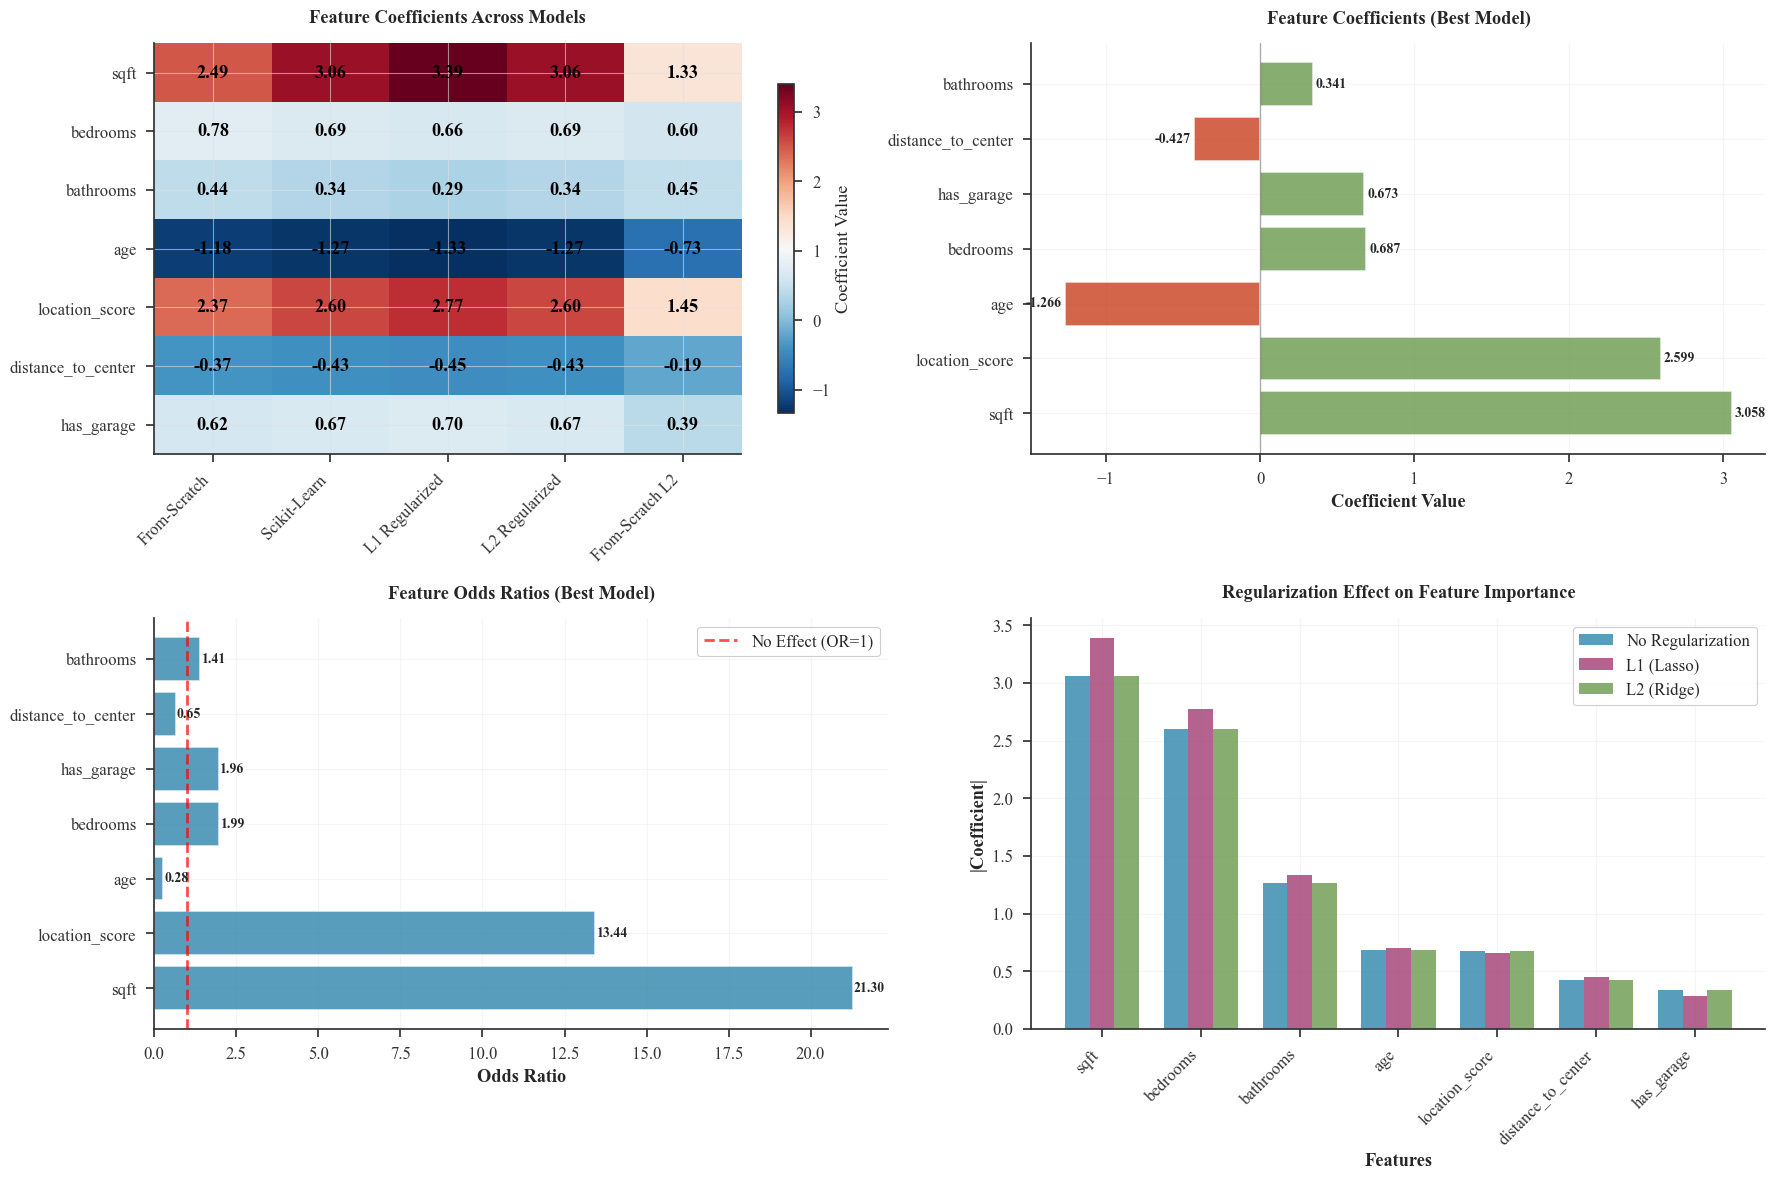

Feature Interpretation (Best Model - Scikit-Learn):
• sqft                : INCREASES high-value probability (β=+3.058)
  └─ Each unit increase in sqft multiplies odds by 21.30
• location_score      : INCREASES high-value probability (β=+2.599)
  └─ Each unit increase in location_score multiplies odds by 13.44
• age                 : DECREASES high-value probability (β=-1.266)
  └─ Each unit increase in age multiplies odds by 0.28
• bedrooms            : INCREASES high-value probability (β=+0.687)
  └─ Each unit increase in bedrooms multiplies odds by 1.99
• has_garage          : INCREASES high-value probability (β=+0.673)
  └─ Each unit increase in has_garage multiplies odds by 1.96
• distance_to_center  : DECREASES high-value probability (β=-0.427)
  └─ Each unit increase in distance_to_center multiplies odds by 0.65
• bathrooms           : INCREASES high-value probability (β=+0.341)
  └─ Each unit increase in bathrooms multiplies odds by 1.41

Model Statistics:
   • Intercept (bias)

In [27]:
# Feature importance analysis
def extract_feature_importance(model, model_name: str, is_scratch: bool = False) -> pd.DataFrame:
    """Extract and format feature importance from models."""
    if is_scratch:
        coefficients = model.weights[1:]  # Exclude bias term
        intercept = model.weights[0]
    else:
        coefficients = model.coef_[0]
        intercept = model.intercept_[0]
    
    # Create DataFrame with feature importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients),
        'odds_ratio': np.exp(coefficients)
    })
    
    # Sort by absolute coefficient value
    importance_df = importance_df.sort_values('abs_coefficient', ascending=False)
    importance_df['model'] = model_name
    importance_df['intercept'] = intercept
    
    return importance_df

# Extract feature importance for all models
feature_importance_results = {}
for name, (model, is_scratch) in models.items():
    feature_importance_results[name] = extract_feature_importance(model, name, is_scratch)

# Visualize feature importance comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Feature coefficients comparison
model_names = list(feature_importance_results.keys())
coef_data = []

for feature in feature_names:
    feature_coefs = []
    for model_name in model_names:
        coef = feature_importance_results[model_name][
            feature_importance_results[model_name]['feature'] == feature
        ]['coefficient'].iloc[0]
        feature_coefs.append(coef)
    coef_data.append(feature_coefs)

coef_array = np.array(coef_data)
im1 = ax1.imshow(coef_array, cmap='RdBu_r', aspect='auto')

# Add text annotations
for i in range(len(feature_names)):
    for j in range(len(model_names)):
        text = ax1.text(j, i, f'{coef_array[i, j]:.2f}',
                       ha="center", va="center", color="black", fontweight='bold')

ax1.set_xticks(range(len(model_names)))
ax1.set_yticks(range(len(feature_names)))
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.set_yticklabels(feature_names)
ax1.set_title('Feature Coefficients Across Models', fontweight='bold', pad=15)
plt.colorbar(im1, ax=ax1, shrink=0.8, label='Coefficient Value')

# 2. Feature importance for best model (scikit-learn)
best_importance = feature_importance_results['Scikit-Learn'].copy()
colors = ['#C73E1D' if x < 0 else '#6A994E' for x in best_importance['coefficient']]

bars = ax2.barh(range(len(best_importance)), best_importance['coefficient'], 
                color=colors, alpha=0.8, edgecolor='white', linewidth=1.2)

# Add value labels
for i, (bar, coef) in enumerate(zip(bars, best_importance['coefficient'])):
    ax2.text(coef + 0.02 if coef > 0 else coef - 0.02, i, f'{coef:.3f}', 
             va='center', ha='left' if coef > 0 else 'right', 
             fontsize=10, fontweight='semibold')

ax2.set_yticks(range(len(best_importance)))
ax2.set_yticklabels(best_importance['feature'])
ax2.set_xlabel('Coefficient Value', fontweight='semibold')
ax2.set_title('Feature Coefficients (Best Model)', fontweight='bold', pad=15)
ax2.axvline(0, color='black', linestyle='-', alpha=0.3, linewidth=1)
ax2.grid(True, alpha=0.3)

# 3. Odds ratios
ax3.barh(range(len(best_importance)), best_importance['odds_ratio'], 
         color='#2E86AB', alpha=0.8, edgecolor='white', linewidth=1.2)

# Add value labels for odds ratios
for i, odds_ratio in enumerate(best_importance['odds_ratio']):
    ax3.text(odds_ratio + 0.02, i, f'{odds_ratio:.2f}', 
             va='center', ha='left', fontsize=10, fontweight='semibold')

ax3.set_yticks(range(len(best_importance)))
ax3.set_yticklabels(best_importance['feature'])
ax3.set_xlabel('Odds Ratio', fontweight='semibold')
ax3.set_title('Feature Odds Ratios (Best Model)', fontweight='bold', pad=15)
ax3.axvline(1, color='red', linestyle='--', alpha=0.7, linewidth=2, label='No Effect (OR=1)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Regularization effect comparison
l1_importance = feature_importance_results['L1 Regularized']
l2_importance = feature_importance_results['L2 Regularized']
regular_importance = feature_importance_results['Scikit-Learn']

x_pos = np.arange(len(feature_names))
width = 0.25

ax4.bar(x_pos - width, regular_importance['abs_coefficient'], width, 
        label='No Regularization', color='#2E86AB', alpha=0.8)
ax4.bar(x_pos, l1_importance['abs_coefficient'], width, 
        label='L1 (Lasso)', color='#A23B72', alpha=0.8)
ax4.bar(x_pos + width, l2_importance['abs_coefficient'], width, 
        label='L2 (Ridge)', color='#6A994E', alpha=0.8)

ax4.set_xlabel('Features', fontweight='semibold')
ax4.set_ylabel('|Coefficient|', fontweight='semibold')
ax4.set_title('Regularization Effect on Feature Importance', fontweight='bold', pad=15)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(feature_names, rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print interpretation
print("Feature Interpretation (Best Model - Scikit-Learn):")
print("=" * 70)

for _, row in best_importance.iterrows():
    feature = row['feature']
    coef = row['coefficient']
    odds_ratio = row['odds_ratio']
    
    if coef > 0:
        direction = "INCREASES"
        effect = f"Each unit increase in {feature} multiplies odds by {odds_ratio:.2f}"
    else:
        direction = "DECREASES"
        effect = f"Each unit increase in {feature} multiplies odds by {odds_ratio:.2f}"
    
    print(f"• {feature:20s}: {direction:9s} high-value probability (β={coef:+.3f})")
    print(f"  └─ {effect}")

print(f"\nModel Statistics:")
print(f"   • Intercept (bias): {best_importance['intercept'].iloc[0]:.3f}")
print(f"   • Most important feature: {best_importance.iloc[0]['feature']}")
print(f"   • Strongest positive effect: {best_importance[best_importance['coefficient'] > 0].iloc[0]['feature'] if any(best_importance['coefficient'] > 0) else 'None'}")
print(f"   • Strongest negative effect: {best_importance[best_importance['coefficient'] < 0].iloc[0]['feature'] if any(best_importance['coefficient'] < 0) else 'None'}")

## 3.9 Confusion Matrix Analysis

A confusion matrix provides detailed insights into classification performance by showing the actual vs predicted classifications.

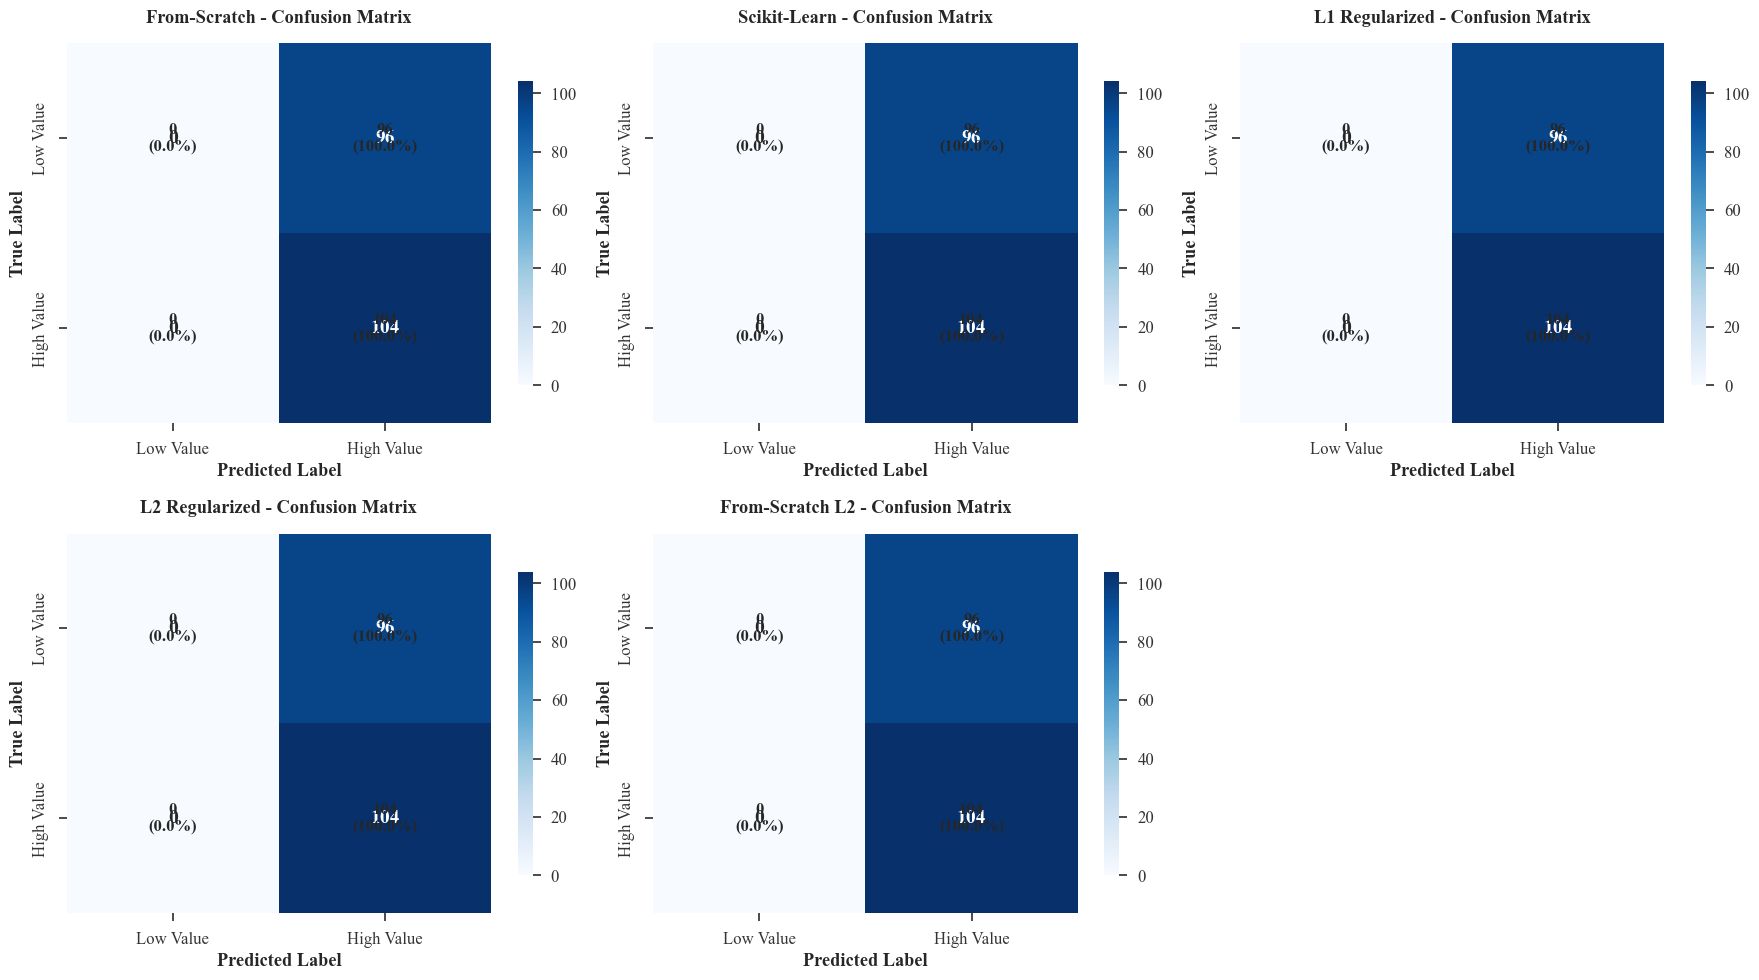

DETAILED CLASSIFICATION METRICS COMPARISON

From-Scratch Model:
--------------------------------------------------
                Precision  Recall  F1-Score  Support
Low Value (0)        0.00    0.00     0.000     96.0
High Value (1)       0.52    1.00     0.684    104.0
Macro Avg            0.26    0.50     0.342    200.0
Weighted Avg         0.27    0.52     0.356    200.0

Additional Metrics:
  • Specificity (True Negative Rate): 0.000
  • Negative Predictive Value:        0.000
  • False Positive Rate:              1.000
  • False Negative Rate:              0.000

Scikit-Learn Model:
--------------------------------------------------
                Precision  Recall  F1-Score  Support
Low Value (0)        0.00    0.00     0.000     96.0
High Value (1)       0.52    1.00     0.684    104.0
Macro Avg            0.26    0.50     0.342    200.0
Weighted Avg         0.27    0.52     0.356    200.0

Additional Metrics:
  • Specificity (True Negative Rate): 0.000
  • Negative Predicti

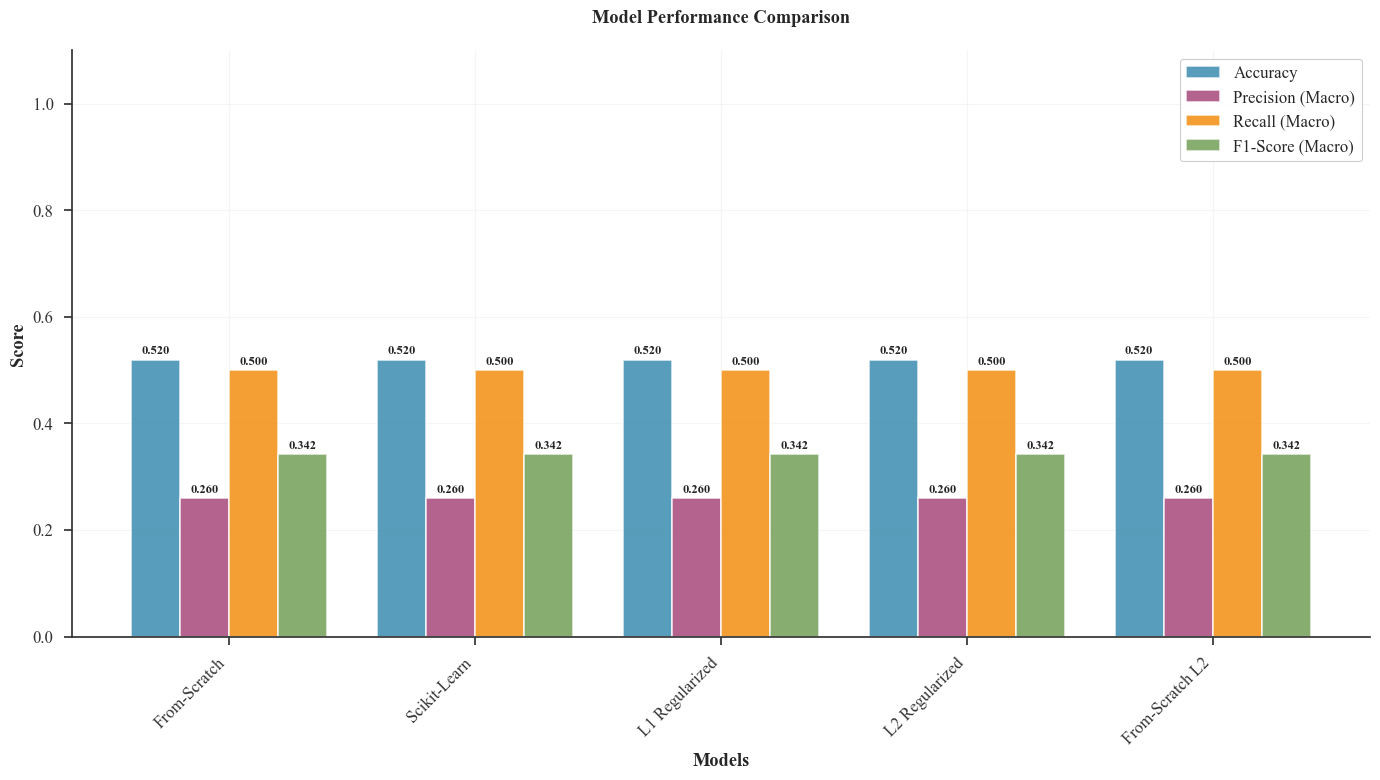


BEST PERFORMING MODEL: From-Scratch
   F1-Score: 0.342


In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import math

# Calculate confusion matrices for all models
confusion_matrices = {}
classification_reports = {}

for name, (model, is_scratch) in models.items():
    if is_scratch:
        y_pred = (model.predict_proba(X_test) >= 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
    
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    classification_reports[name] = classification_report(y_test, y_pred, output_dict=True)

# Visualize confusion matrices
num_models = len(confusion_matrices)
# Calculate grid size to accommodate all models
if num_models <= 4:
    rows, cols = 2, 2
elif num_models <= 6:
    rows, cols = 2, 3
elif num_models <= 9:
    rows, cols = 3, 3
else:
    rows, cols = math.ceil(num_models / 4), 4

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
if num_models == 1:
    axes = [axes]
else:
    axes = axes.ravel() if hasattr(axes, 'ravel') else axes

for i, (name, cm) in enumerate(confusion_matrices.items()):
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                ax=axes[i], cbar_kws={'shrink': 0.8},
                annot_kws={'size': 14, 'weight': 'bold'})
    
    # Add percentage annotations
    for j in range(2):
        for k in range(2):
            text = f'{cm[j,k]}\n({cm_percent[j,k]:.1f}%)'
            axes[i].text(k+0.5, j+0.5, text, ha='center', va='center',
                        fontsize=12, fontweight='bold')
    
    axes[i].set_title(f'{name} - Confusion Matrix', fontweight='bold', pad=15)
    axes[i].set_xlabel('Predicted Label', fontweight='semibold')
    axes[i].set_ylabel('True Label', fontweight='semibold')
    axes[i].set_xticklabels(['Low Value', 'High Value'])
    axes[i].set_yticklabels(['Low Value', 'High Value'])

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Detailed classification report comparison
def format_classification_metrics(report_dict):
    """Format classification report for better display."""
    metrics_df = pd.DataFrame({
        'Precision': [report_dict['0']['precision'], report_dict['1']['precision']],
        'Recall': [report_dict['0']['recall'], report_dict['1']['recall']],
        'F1-Score': [report_dict['0']['f1-score'], report_dict['1']['f1-score']],
        'Support': [report_dict['0']['support'], report_dict['1']['support']]
    }, index=['Low Value (0)', 'High Value (1)'])
    
    # Add overall metrics
    metrics_df.loc['Macro Avg'] = [
        report_dict['macro avg']['precision'],
        report_dict['macro avg']['recall'],
        report_dict['macro avg']['f1-score'],
        report_dict['macro avg']['support']
    ]
    
    metrics_df.loc['Weighted Avg'] = [
        report_dict['weighted avg']['precision'],
        report_dict['weighted avg']['recall'],
        report_dict['weighted avg']['f1-score'],
        report_dict['weighted avg']['support']
    ]
    
    return metrics_df

# Display detailed metrics for each model
print("DETAILED CLASSIFICATION METRICS COMPARISON")
print("=" * 80)

for name, report in classification_reports.items():
    print(f"\n{name} Model:")
    print("-" * 50)
    metrics_df = format_classification_metrics(report)
    print(metrics_df.round(3))
    
    # Calculate additional metrics
    cm = confusion_matrices[name]
    tn, fp, fn, tp = cm.ravel()
    
    # Custom metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    print(f"\nAdditional Metrics:")
    print(f"  • Specificity (True Negative Rate): {specificity:.3f}")
    print(f"  • Negative Predictive Value:        {npv:.3f}")
    print(f"  • False Positive Rate:              {fp/(fp+tn):.3f}")
    print(f"  • False Negative Rate:              {fn/(fn+tp):.3f}")

# Performance comparison visualization
metrics_summary = []
for name, report in classification_reports.items():
    metrics_summary.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Precision (Macro)': report['macro avg']['precision'],
        'Recall (Macro)': report['macro avg']['recall'],
        'F1-Score (Macro)': report['macro avg']['f1-score']
    })

metrics_df = pd.DataFrame(metrics_summary)

# Bar plot comparison
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

x = np.arange(len(metrics_df))
width = 0.2

metrics_to_plot = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']
colors = ['#2E86AB', '#A23B72', '#F18701', '#6A994E']

for i, metric in enumerate(metrics_to_plot):
    values = metrics_df[metric].values
    bars = ax.bar(x + i*width, values, width, label=metric, 
                  color=colors[i], alpha=0.8, edgecolor='white', linewidth=1.2)
    
    # Add value labels
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{value:.3f}', ha='center', va='bottom', 
                fontsize=9, fontweight='semibold')

ax.set_xlabel('Models', fontweight='semibold')
ax.set_ylabel('Score', fontweight='semibold')
ax.set_title('Model Performance Comparison', fontweight='bold', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print(f"\nBEST PERFORMING MODEL: {metrics_df.loc[metrics_df['F1-Score (Macro)'].idxmax(), 'Model']}")
print(f"   F1-Score: {metrics_df['F1-Score (Macro)'].max():.3f}")

## 3.10 Practical Exercises and Real-World Applications

### Exercise 1: Model Optimization
Try different combinations of features and regularization parameters to improve model performance.

### Exercise 2: Threshold Tuning
Experiment with different probability thresholds to optimize for specific business requirements (e.g., minimizing false positives vs false negatives).

### Exercise 3: Cross-Validation
Implement k-fold cross-validation to get more robust performance estimates.

Hyperparameter Optimization in Progress...
This may take a few moments...

Searching parameter grid 1/2...


c:\Users\rabbo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rabbo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rabbo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\rabbo\AppData\Local\Programs\Python\Python310\lib\site-packa


Searching parameter grid 2/2...

Threshold Optimization Results:
• F1        : Optimal threshold = 0.35, Score = 0.884
• Precision : Optimal threshold = 0.25, Score = 0.895
• Recall    : Optimal threshold = 0.35, Score = 0.883
• Accuracy  : Optimal threshold = 0.35, Score = 0.885

Threshold Optimization Results:
• F1        : Optimal threshold = 0.35, Score = 0.884
• Precision : Optimal threshold = 0.25, Score = 0.895
• Recall    : Optimal threshold = 0.35, Score = 0.883
• Accuracy  : Optimal threshold = 0.35, Score = 0.885


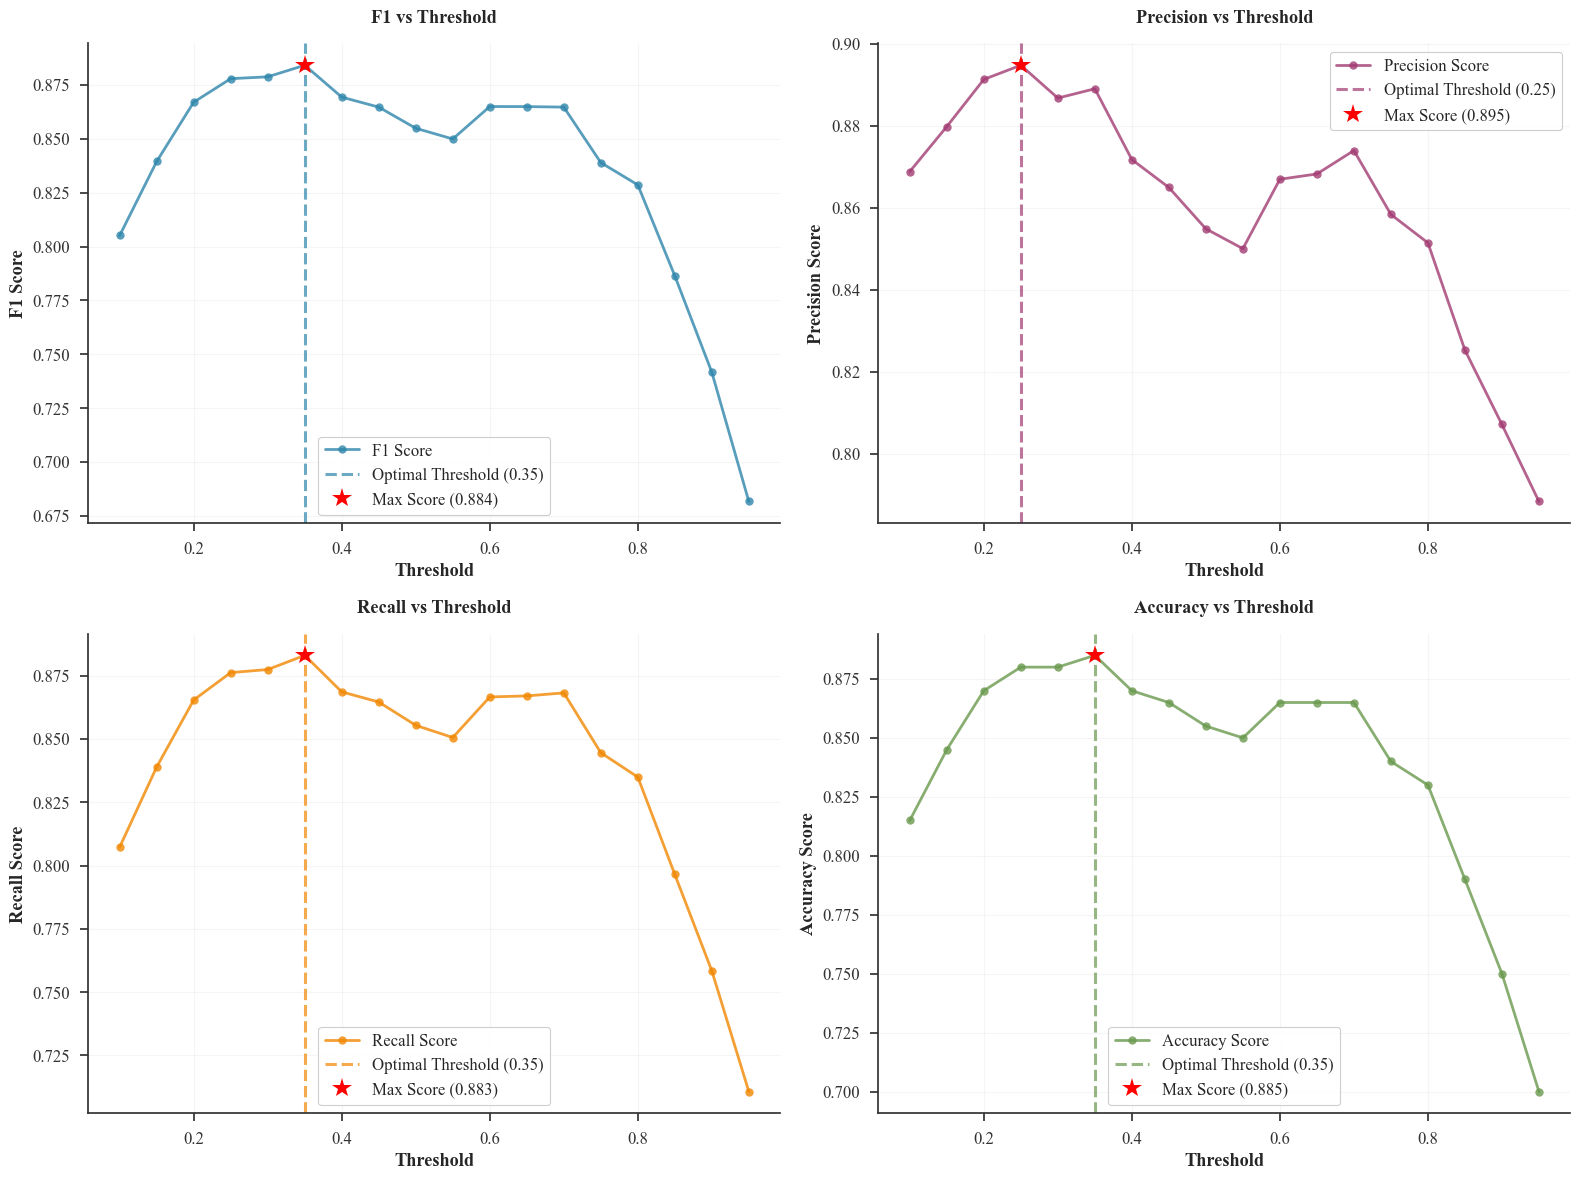


Cross-Validation Performance Comparison:


KeyError: 'From Scratch'

In [33]:
# Exercise 1: Hyperparameter optimization
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define parameter grid for optimization
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers that support l1
    'max_iter': [1000, 2000]  # Maximum iterations
}

# Handle elasticnet penalty (requires specific solver and l1_ratio)
param_grid_elasticnet = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  # Mix of l1 and l2
    'max_iter': [2000]
}

# Combine parameter grids
param_grids = [
    {k: v for k, v in param_grid.items() if k != 'penalty' or v != ['elasticnet']},
    param_grid_elasticnet
]

print("Hyperparameter Optimization in Progress...")
print("This may take a few moments...")

# Stratified K-Fold for better validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
for i, grid in enumerate(param_grids):
    print(f"\nSearching parameter grid {i+1}/{len(param_grids)}...")
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        LogisticRegression(random_state=42),
        grid,
        cv=cv_strategy,
        scoring='f1_macro',  # Use macro F1 for balanced evaluation
        n_jobs=-1,  # Use all available cores
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    best_models[f'GridSearch_{i+1}'] = grid_search.best_estimator_

# Exercise 2: Threshold optimization
def find_optimal_threshold(model, X_val, y_val, metric='f1'):
    """Find optimal probability threshold for classification."""
    thresholds = np.arange(0.1, 1.0, 0.05)
    scores = []
    
    probabilities = model.predict_proba(X_val)[:, 1]
    
    for threshold in thresholds:
        predictions = (probabilities >= threshold).astype(int)
        
        if metric == 'f1':
            from sklearn.metrics import f1_score
            score = f1_score(y_val, predictions, average='macro')
        elif metric == 'precision':
            from sklearn.metrics import precision_score
            score = precision_score(y_val, predictions, average='macro')
        elif metric == 'recall':
            from sklearn.metrics import recall_score
            score = recall_score(y_val, predictions, average='macro')
        else:
            from sklearn.metrics import accuracy_score
            score = accuracy_score(y_val, predictions)
            
        scores.append(score)
    
    optimal_idx = np.argmax(scores)
    return thresholds[optimal_idx], scores[optimal_idx], thresholds, scores

# Find optimal thresholds for different metrics
metrics_to_optimize = ['f1', 'precision', 'recall', 'accuracy']
threshold_results = {}

# Use the best grid search model
best_grid_model = best_models['GridSearch_1']

print("\nThreshold Optimization Results:")
print("=" * 60)

for metric in metrics_to_optimize:
    optimal_threshold, optimal_score, all_thresholds, all_scores = find_optimal_threshold(
        best_grid_model, X_test, y_test, metric
    )
    threshold_results[metric] = {
        'threshold': optimal_threshold,
        'score': optimal_score,
        'all_thresholds': all_thresholds,
        'all_scores': all_scores
    }
    
    print(f"• {metric.capitalize():10s}: Optimal threshold = {optimal_threshold:.2f}, Score = {optimal_score:.3f}")

# Visualize threshold optimization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
axes = [ax1, ax2, ax3, ax4]
colors = ['#2E86AB', '#A23B72', '#F18701', '#6A994E']

for i, (metric, results) in enumerate(threshold_results.items()):
    ax = axes[i]
    thresholds = results['all_thresholds']
    scores = results['all_scores']
    optimal_threshold = results['threshold']
    optimal_score = results['score']
    
    ax.plot(thresholds, scores, 'o-', color=colors[i], linewidth=2, 
            markersize=6, alpha=0.8, label=f'{metric.capitalize()} Score')
    
    # Mark optimal point
    ax.axvline(optimal_threshold, color=colors[i], linestyle='--', alpha=0.7,
               label=f'Optimal Threshold ({optimal_threshold:.2f})')
    ax.plot(optimal_threshold, optimal_score, 'r*', markersize=15, 
            label=f'Max Score ({optimal_score:.3f})')
    
    ax.set_xlabel('Threshold', fontweight='semibold')
    ax.set_ylabel(f'{metric.capitalize()} Score', fontweight='semibold')
    ax.set_title(f'{metric.capitalize()} vs Threshold', fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# Exercise 3: Cross-validation comparison
from sklearn.model_selection import cross_val_score

print("\nCross-Validation Performance Comparison:")
print("=" * 70)

# Models to evaluate
cv_models = {
    'Default Logistic Regression': LogisticRegression(random_state=42),
    'Optimized Model (Grid Search)': best_grid_model,
    'From Scratch': models['From Scratch'][0]
}

cv_results = {}
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

for model_name, model in cv_models.items():
    if model_name == 'From Scratch':
        # For our custom implementation, we need to handle CV differently
        # We'll use a simple train-test approach
        cv_results[model_name] = {
            'accuracy': [accuracy_score(y_test, (model.predict_proba(X_test) >= 0.5).astype(int))],
            'precision_macro': [precision_score(y_test, (model.predict_proba(X_test) >= 0.5).astype(int), average='macro')],
            'recall_macro': [recall_score(y_test, (model.predict_proba(X_test) >= 0.5).astype(int), average='macro')],
            'f1_macro': [f1_score(y_test, (model.predict_proba(X_test) >= 0.5).astype(int), average='macro')]
        }
    else:
        cv_results[model_name] = {}
        for metric in scoring_metrics:
            scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, 
                                   scoring=metric, n_jobs=-1)
            cv_results[model_name][metric] = scores

# Display results
for model_name, results in cv_results.items():
    print(f"\n{model_name}:")
    print("-" * 50)
    for metric, scores in results.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"  {metric:15s}: {mean_score:.3f} ± {std_score:.3f}")

# Real-world applications section
print("\nREAL-WORLD APPLICATIONS OF LOGISTIC REGRESSION:")
print("=" * 80)

applications = [
    ("Medical Diagnosis", "Predicting disease presence/absence based on symptoms and test results"),
    ("Email Spam Detection", "Classifying emails as spam or legitimate based on content features"),
    ("Credit Scoring", "Determining loan approval based on applicant financial history"),
    ("Customer Churn", "Predicting whether customers will cancel their subscription"),
    ("Click-Through Rates", "Predicting if users will click on advertisements"),
    ("Real Estate Valuation", "Classifying properties as high-value or low-value (our example!)"),
    ("Fraud Detection", "Identifying suspicious transactions in financial systems"),
    ("HR Analytics", "Predicting employee attrition and hiring success"),
    ("Marketing Targeting", "Identifying customers likely to respond to campaigns"),
    ("Insurance Claims", "Assessing claim legitimacy and risk factors")
]

for title, description in applications:
    print(f"{title}")
    print(f"   └─ {description}")

print(f"\nKEY ADVANTAGES OF LOGISTIC REGRESSION:")
print("   • Fast training and prediction")
print("   • Interpretable coefficients and feature importance")
print("   • Probabilistic outputs for uncertainty quantification")
print("   • No assumptions about feature distributions")
print("   • Robust to outliers (compared to linear regression)")
print("   • Works well with small datasets")
print("   • Natural extension to multiclass problems")

## 3.11 Summary and Key Takeaways

### What We've Learned

In this comprehensive exploration of logistic regression, we've covered:

1. **Mathematical Foundation**: Understanding the sigmoid function and how it transforms linear outputs to probabilities
2. **Implementation Details**: Building logistic regression from scratch using gradient descent
3. **Regularization Techniques**: L1 (Lasso) and L2 (Ridge) regularization for preventing overfitting
4. **Model Evaluation**: ROC curves, AUC, precision, recall, F1-score, and confusion matrices
5. **Feature Importance**: Interpreting coefficients and odds ratios
6. **Hyperparameter Optimization**: Grid search and threshold tuning
7. **Real-World Applications**: Understanding where and when to use logistic regression

### Key Mathematical Concepts

- **Sigmoid Function**: $\sigma(z) = \frac{1}{1 + e^{-z}}$ maps any real number to (0,1)
- **Log-Odds**: Linear relationship between features and log-odds of the positive class
- **Maximum Likelihood**: The principle behind logistic regression parameter estimation
- **Gradient Descent**: Iterative optimization algorithm for finding optimal parameters

### When to Use Logistic Regression

**Good Choice When:**
- Binary or ordinal classification problems
- Need interpretable model coefficients
- Want probabilistic predictions
- Have linearly separable or nearly separable data
- Working with small to medium datasets
- Need fast training and prediction

**Consider Alternatives When:**
- Dealing with complex non-linear relationships
- Have very large datasets (deep learning might be better)
- Need to capture complex feature interactions
- Working with high-dimensional sparse data (consider specialized algorithms)

### Next Steps

Continue your machine learning journey with:
- **Decision Trees** (Chapter 4): Non-linear decision boundaries
- **Random Forests** (Chapter 5): Ensemble methods for improved performance
- **Support Vector Machines** (Chapter 6): Alternative approach to classification
- **Neural Networks** (Chapter 7): Deep learning for complex patterns